In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema
from tqdm import tqdm

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

In [2]:
source_directory = f"D:/Courses/Uclouvain/thesis/code/these_Colin/seismogram_curve_extraction/data/ground_truths/overlap_20_images/"

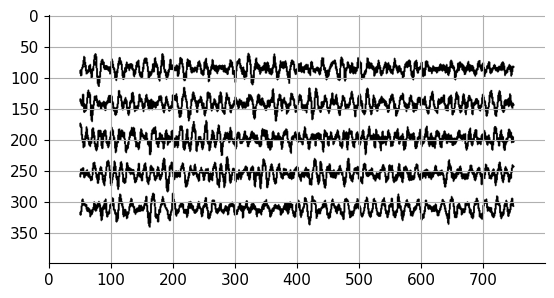

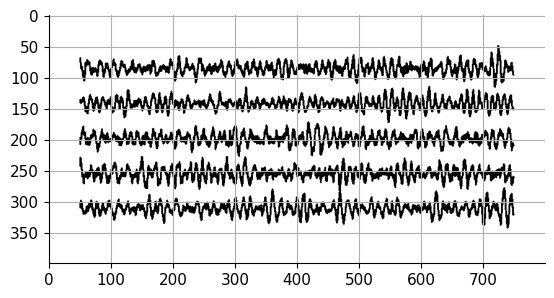

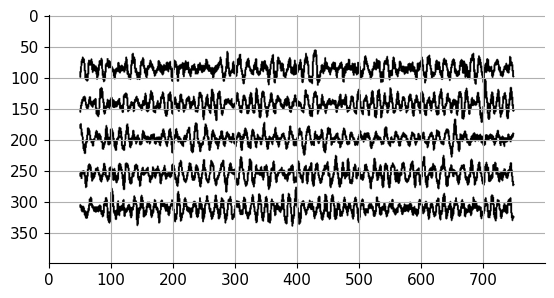

In [3]:
count = 0
saved_images = []  # List to store images

for image_file in os.listdir(source_directory):
    if image_file.endswith('_binary.jpg'):
        image_file = os.path.join(source_directory, image_file)
        saved_images.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))
        if count < 3:
            plt.imshow(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE), cmap='gray')
            plt.show()
            count += 1

saved_images = np.array(saved_images)


In [4]:
# Get the ROI of the images
def get_roi(image):
    temp_image = - (image - np.max(image))
    # Get the row and column indices of the non-zero elements
    rows, cols = np.nonzero(temp_image)
    # Get the minimum and maximum row and column indices
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    # Get the ROI of the image
    roi = image[min_row:max_row + 1, min_col:max_col + 1]
    return roi

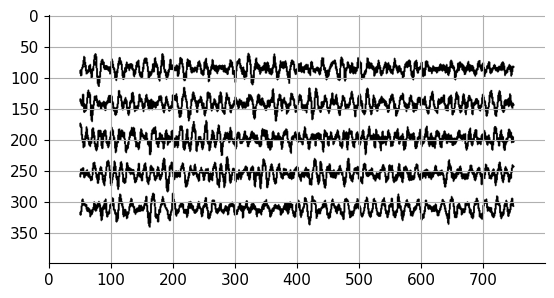

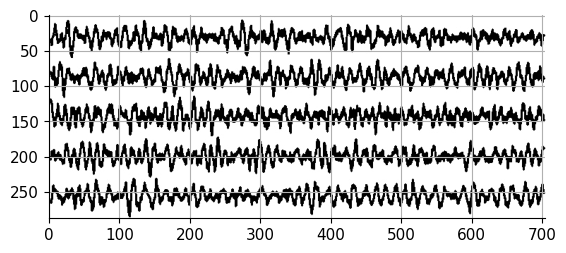

In [5]:
plt.imshow(saved_images[0], cmap='gray')
plt.show()

# Get the ROI of all the images
new_saved_images = []
for image in saved_images:
    new_saved_images.append(np.array(get_roi(image)))

saved_images = new_saved_images

plt.imshow(saved_images[0], cmap='gray')
plt.show()

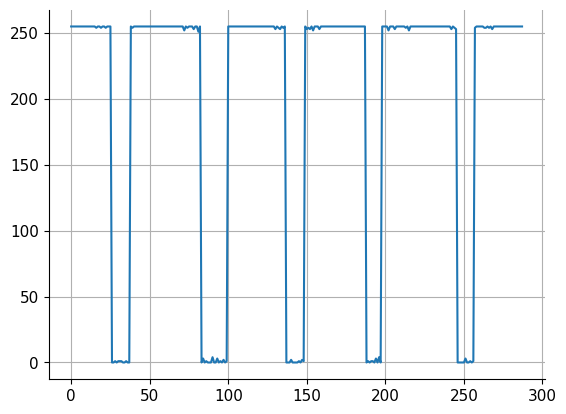

In [6]:
# plot one column of the image
plt.plot(saved_images[0][:, len(saved_images[0][0])//2])
plt.show()

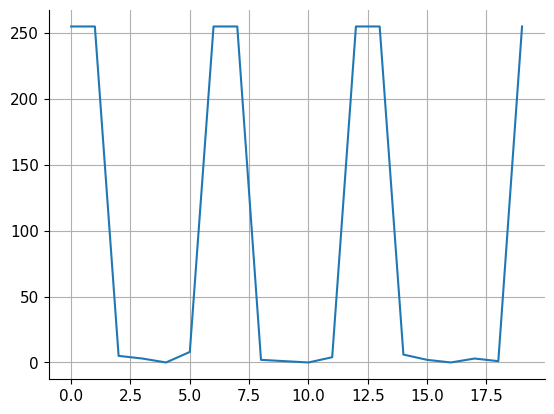

Number of connected components: 3
Average thickness: 4.333333333333333


In [7]:
def count_components_and_avg_thickness(arr, threshold=10):
    """
    Counts the number of connected components where values are close to 0 
    and computes the average thickness.

    Parameters:
    - arr: 1D numpy array containing grayscale values (0 to 255).
    - threshold: Defines what is considered "close to 0" (default: 10).

    Returns:
    - count: Number of connected components.
    - avg_thickness: Average thickness of components.
    """
    count = 0
    thicknesses = []
    n = len(arr)
    
    i = 0
    while i < n:
        if arr[i] < threshold:  # Found a new component (close to 0)
            count += 1
            start = i
            while i < n and arr[i] < threshold:  # Continue until background (255)
                i += 1
            thicknesses.append(i - start)
        else:
            i += 1

    avg_thickness = np.mean(thicknesses) if thicknesses else 0
    return count, avg_thickness

# Example usage
binary_array = np.array([255, 255, 5, 3, 0, 8, 255, 255, 2, 1, 0, 4, 255, 255, 6, 2, 0, 3, 1, 255])
num_components, avg_thickness = count_components_and_avg_thickness(binary_array)

plt.plot(binary_array)
plt.show()

print(f"Number of connected components: {num_components}")
print(f"Average thickness: {avg_thickness}")


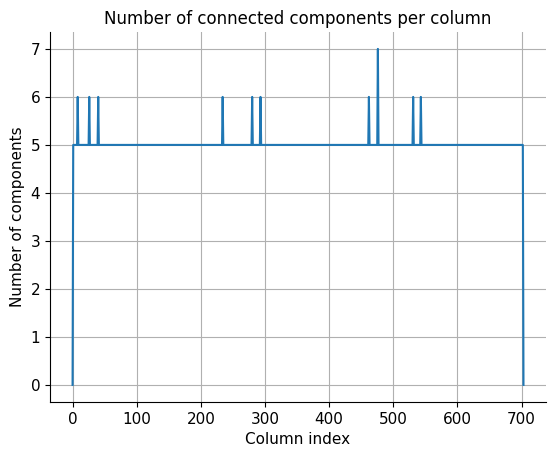

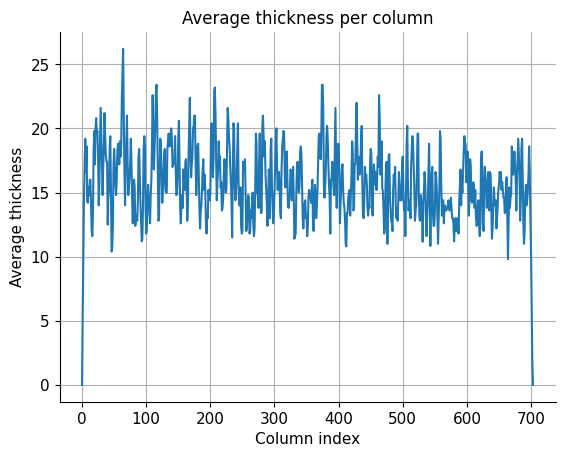

Average number of components: 5 VS true value is 5
Average thickness: 15 VS true value is 15


In [8]:
# apply to the columns of the image and compute the average thickness, average number of components
N_components = []
thickness = []

for i in range(saved_images[0].shape[1]):
    n, t = count_components_and_avg_thickness(saved_images[0][:, i])
    N_components.append(n)
    thickness.append(t)

plt.plot(N_components)
plt.title("Number of connected components per column")
plt.xlabel("Column index")
plt.ylabel("Number of components")
plt.show()

plt.plot(thickness)
plt.title("Average thickness per column")
plt.xlabel("Column index")
plt.ylabel("Average thickness")
plt.show()

# compute the average thickness and number of components for all images by ignoring the columns with no components
N_components = np.array(N_components)
thickness = np.array(thickness)
N_components = N_components[N_components > 1e-6]
thickness = thickness[thickness > 1e-6]

avg_N_components = int(np.mean(N_components))
avg_thickness = int(np.mean(thickness))
print(f"Average number of components: {int(np.mean(N_components))} VS true value is 5")
print(f"Average thickness: {int(np.mean(thickness))} VS true value is 15")


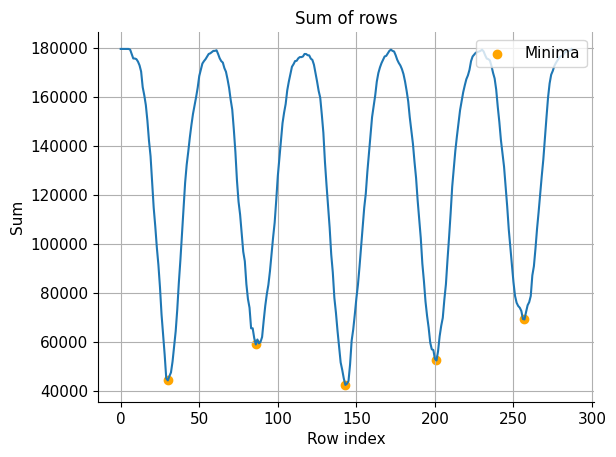

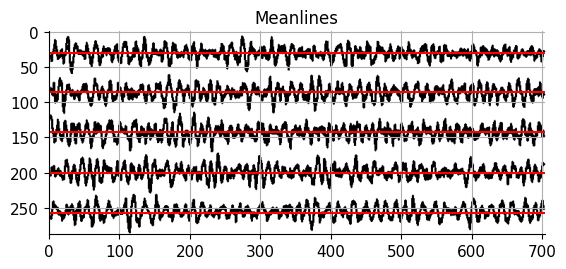

In [9]:
# find the meanlines of each curves in the image
# sum the rows of the image
sum_rows = np.sum(saved_images[0], axis=1)

# Find local minima
min_indices = argrelextrema(sum_rows, np.less, order=10)[0]
sorted_minima = min_indices[np.argsort(sum_rows[min_indices])]

plt.plot(sum_rows)
plt.scatter(sorted_minima[:avg_N_components], sum_rows[sorted_minima[:avg_N_components]], color='orange', label="Minima")
plt.legend()
plt.title("Sum of rows")
plt.xlabel("Row index")
plt.ylabel("Sum")
plt.show()

# The meanlines are the num_components rows with the minimum sum
meanlines = sorted_minima[:avg_N_components]

plt.imshow(saved_images[0], cmap='gray')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines")
plt.show()

In [10]:
# Find the starting point of each component
starting_points = []

# iterate over the columns of the image until

In [11]:
# Implement the Kalman Filter to track the curves around the meanlines

# Define the prediction step
def predict(X, P, A, Q):
    X = A @ X
    P = A @ P @ A.T + Q
    return X, P

# Define the update step
def update(X, P, Z, H, R):
    if (H @ P @ H.T + R).shape[1] == (H @ P @ H.T + R).shape[1] == 1: K = (P @ H.T) / (H @ P @ H.T + R)
    else: K = np.linalg.solve(H @ P @ H.T + R, P @ H.T)
    X = X + K @ (Z - H @ X)
    P = P - K @ H @ P
    return X, P

In [ ]:
# Define the state transition matrix
Delta = 1 # Time step [pixels]
A = np.array([[1, Delta, Delta**2/2],
              [0, 1, Delta],
              [0, 0, 1]])   

H = np.array([[1, 0, 0]])

# Define the process noise covariance matrix
sigma_a = 0.1
Q = np.array([[0, 0, 0],
              [0, sigma_a**2, 0],
              [0, 0, 0]])

# Define the measurement noise covariance matrix
sigma_z = 1
R = np.array([[sigma_z**2]])

# Initialize the state and covariance
X = np.array([[meanlines[-1]], [0], [0]])  # Initial state: [position, velocity, acceleration]
P = np.eye(3) * 1  # Initial covariance

# Initialize the list of estimated positions
estimated_positions = [X[0, 0]]



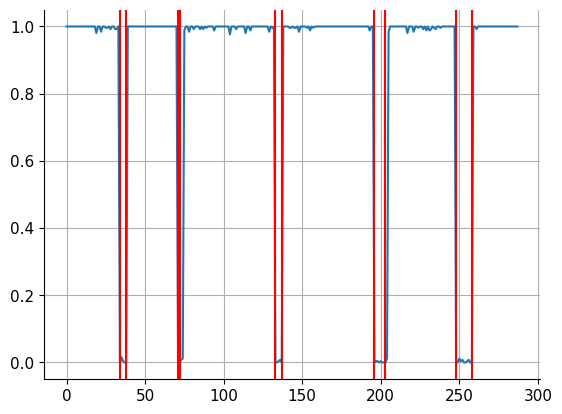

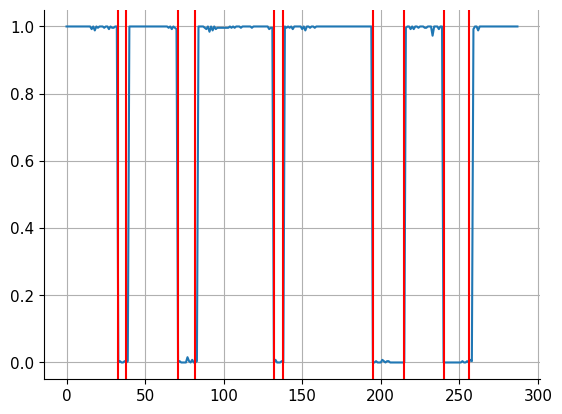

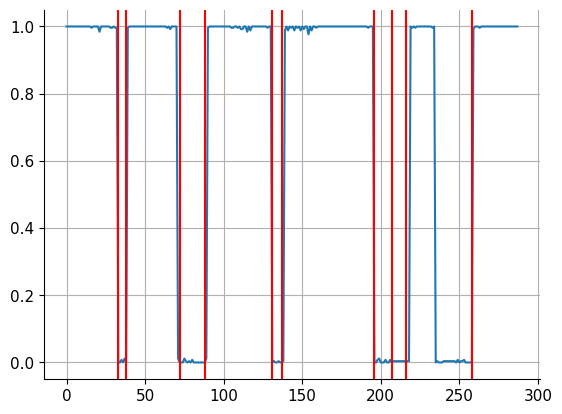

In [13]:
# Iterate over the columns of the image, 0 value pixels vertical position are the measurements
sel = 10
tresh = 1e-3
spacing = avg_thickness/2 # number of pixels
count = 0
positions = np.full((avg_N_components, 2), np.nan) # contains start and stop positions of each trace for each component
measurements = np.full((saved_images[sel].shape[1], avg_N_components), np.nan) # contains the position of the measurements for each component

for col_idx in range(saved_images[sel].shape[1]):
    col = saved_images[sel][:, col_idx].astype(np.float64)
    if col.max() - col.min() > 0: col /= col.max() - col.min()

    # find the 0 value pixels, with a given treshold
    temp = np.where(col < tresh)[0]
    if len(temp) == 0: continue

    val_prev = temp[0]
    i = 0
    positions[i, 0] = val_prev

    # print(measurements)

    for val in temp[1:]:
        if val - val_prev > spacing and i < avg_N_components:
            positions[i, 1] = val_prev
            i += 1
            if i < avg_N_components: positions[i, 0] = val
        val_prev = val
    positions[-1, 1] = val

    # print(positions)

    # plot the measurements
    if count < 3:
        plt.figure()
        plt.plot(col)
        # plot vertical lines at the positions of the measurements
        for pos in positions:
            plt.axvline(pos[0], color='r')
            plt.axvline(pos[1], color='r')
        plt.show
        # delete
        count += 1
    
    for i in range(avg_N_components):
        if not np.isnan(positions[i, 0]):
            measurements[col_idx, i] = (positions[i, 1] + positions[i, 0]) / 2
        
# measurements[col_idx, i] = positions[i, 1] 


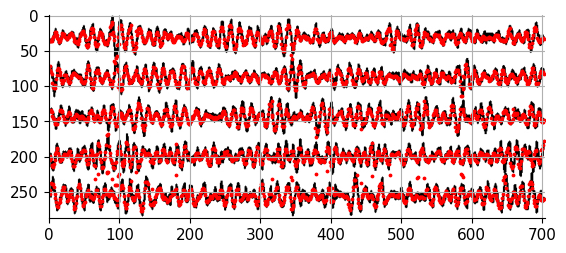

In [14]:
plt.imshow(saved_images[sel], cmap='gray')

# add white noise to the measurements
# sigma_noise = 5
# measurements += np.random.normal(0, sigma_noise, measurements.shape)

# Vectorized scatter plotting
for i in range(avg_N_components):
    valid_indices = ~np.isnan(measurements[:, i])  # Get valid (non-NaN) indices
    plt.scatter(np.where(valid_indices)[0], measurements[valid_indices, i], color='r', s=3)

plt.show()

In [15]:
# Now we can apply the Kalman filter to track the curves around the meanlines
for k in tqdm(range(1, saved_images[sel].shape[1]), desc="Processing columns"):
    # Predict
    X, P = predict(X, P, A, Q)

    # Update
    # for i in range(avg_N_components):
    i = 0
    if True:
        if not np.isnan(measurements[k, i]):            
            X, P = update(X, P, measurements[k, i], H, R)
    
    # Save the estimated position
    estimated_positions.append(X[0, 0])

Processing columns: 100%|██████████| 703/703 [00:00<00:00, 18502.27it/s]


(704,)


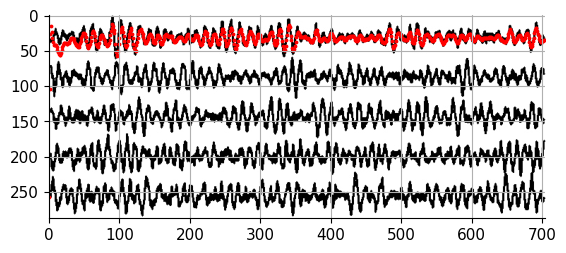

In [16]:
# Plot the estimated positions
plt.imshow(saved_images[sel], cmap='gray')

estimated_positions = np.array(estimated_positions)
print(estimated_positions.shape)
# for i in range(avg_N_components):
i = 0
if True:
    valid_indices = ~np.isnan(estimated_positions)  # Get valid (non-NaN) indices
    plt.scatter(np.where(valid_indices)[0], estimated_positions[valid_indices], color='r', s=3)

plt.show()